## 1.Importing libraries

In [106]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

## 2. Data Loading

In [94]:
Main_dir = "/Users/somesh/Desktop/IITH_PROJECTS/Human_Emotion_detector"
Text_data_dir = "/Users/somesh/Desktop/IITH_PROJECTS/Human_Emotion_detector/Text_data"

In [95]:
Text_data_Path = os.path.join(Text_data_dir, "text.txt")
text_df = pd.read_csv(Text_data_Path, sep=";", names=['content','sentiment'])
print(f"shape of text data: {text_df.shape}")
text_df.head()

shape of text data: (16000, 2)


,content,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## 3.Check for duplicates in Data

In [96]:
# Count duplicates
duplicates_count = text_df.duplicated().sum()
print(f'Total duplicated rows: {duplicates_count}')

Total duplicated rows: 1


In [97]:
text_df[text_df['content'].duplicated()== True].shape

(31, 2)

In [41]:
# index = text_df[text_df['content'].duplicated()== True].index
# # Drop duplicates
# text_df.drop(index, inplace=True)
# # Reset index after dropping duplicates
# text_df.reset_index(drop=True, inplace=True)
# print(f"shape of text data after removing duplicates: {text_df.shape}")

shape of text data after removing duplicates: (15969, 2)


In [98]:
#unique sentiments
unique_sentiments = text_df['sentiment'].unique()
print(f"unique sentiments: {unique_sentiments}")

unique sentiments: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


## 4. Analysing data and make it balance

           count  percentage
sentiment                   
joy         5362    33.51250
sadness     4666    29.16250
anger       2159    13.49375
fear        1937    12.10625
love        1304     8.15000
surprise     572     3.57500


<Axes: ylabel='sentiment'>

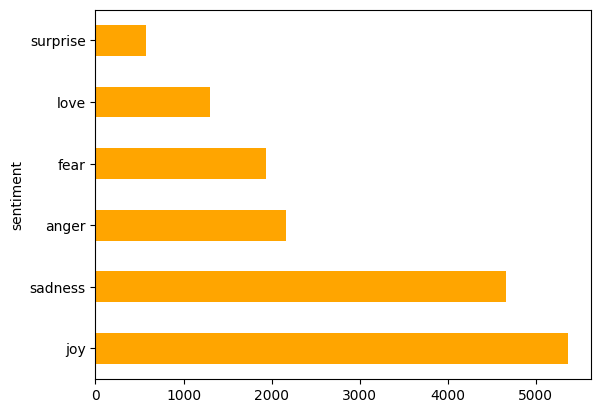

In [99]:

frequency_counts = text_df['sentiment'].value_counts()
frequency_percentage = (frequency_counts / len(text_df['sentiment'])) * 100

# print(frequency_counts)

frequency_df = pd.DataFrame(data={'count' : frequency_counts, 'percentage' : frequency_percentage})
print(frequency_df)

text_df['sentiment'].value_counts().plot(kind='barh',color='orange')

In [100]:
text_df = text_df[text_df.sentiment != "surprise"]

In [101]:
dfs = []
size = len(text_df)

for cls, sub in text_df.groupby("sentiment"):
    if cls in ("sadness", "joy"):
        # down‑sample
        dfs.append(sub.sample(int(0.75 * len(sub)), random_state=23))
    else:
        # keep all of the smaller classes intact
        dfs.append(sub)

text_df = pd.concat(dfs).sample(frac=1, random_state=42)  # shuffle

           count  percentage
sentiment                   
anger       2159   25.230805
fear        1937   22.636438
joy         1688   19.726540
sadness     1469   17.167232
love        1304   15.238986


<Axes: ylabel='sentiment'>

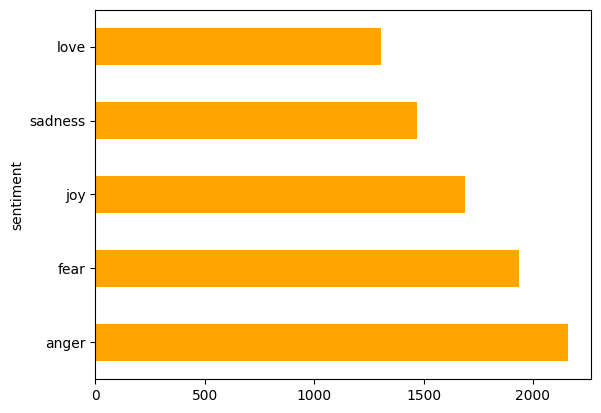

In [71]:

frequency_counts = text_df['sentiment'].value_counts()
frequency_percentage = (frequency_counts / len(text_df['sentiment'])) * 100

# print(frequency_counts)

frequency_df = pd.DataFrame(data={'count' : frequency_counts, 'percentage' : frequency_percentage})
print(frequency_df)

text_df['sentiment'].value_counts().plot(kind='barh',color='orange')

In [102]:
SENTIMENT_CLASS = text_df['sentiment'].unique()
print(f"sentiment classes: {SENTIMENT_CLASS}")

sentiment classes: ['sadness' 'joy' 'anger' 'love' 'fear']


## 5.CLEAN AND LABEL THE DATA

In [103]:
import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def clean_content(text):
    
    text = re.sub(r'[^a-zA-Z]',' ',text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = text.lower()
    
    text = text.split()  
    
    text = [word for word in text if word not in stop_words and len(word)>1]
    
    text = [stemmer.stem(word) for word in text]
    
    text = " ".join(text)
    
    return text

clean_content("tun 299ijif  npggrgmg % %%$$ v jnnrnr%%8 httpdmfnf//e www.google.com ")

text_df['content'] = text_df['content'].apply(clean_content)
text_df['content'].head()
    
    
    
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/somesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/somesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


8702                   worri would awkward would feel lone
6252                          feel awkward talk book begin
2548     still feel like kid eager blow candl open gift...
11287                      wake ill feel realli realli mad
1005     want tell peopl first made feel want think gor...
Name: content, dtype: object

## 6. Splitting of data into train and test

In [104]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline


X_train,X_test,y_train,y_test = train_test_split(text_df['content'], text_df['sentiment'], test_size=0.2, random_state=23,shuffle=True)

text_Encoder = LabelEncoder()
y_train = text_Encoder.fit_transform(y_train)
y_test = text_Encoder.transform(y_test)
SENTIMENT_CLASS_NAMES = text_Encoder.classes_ 

print(f"Class names: {SENTIMENT_CLASS_NAMES}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



Class names: ['anger' 'fear' 'joy' 'love' 'sadness']
X_train shape: (10336,), y_train shape: (10336,)
X_test shape: (2584,), y_test shape: (2584,)


## 7. Building ML models(Logistic Regression , SVC, Decision tree Classifier) WITH tfidf Vectoizer techinque in Pipeline

In [108]:
from sklearn.linear_model import LogisticRegression

starttime = time.time()

LR_PIPE = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2),min_df =1,smooth_idf=True,norm='l2')),
    ('lr_clf',LogisticRegression(random_state=23,solver='liblinear'))
])

param_grid = {
    'tfidf__max_features': [2000, 3000, 5000],
    'tfidf__sublinear_tf': [True, False],
    
    'lr_clf__C': [0.1, 1, 0.5, 2],
}

grid_search = GridSearchCV(LR_PIPE, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

lr_best_model = grid_search.best_estimator_
y_pred = lr_best_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(f"Time taken: {time.time() - starttime} seconds")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'lr_clf__C': 2, 'tfidf__max_features': 5000, 'tfidf__sublinear_tf': True}
Best score: 0.8735491124692247
Accuracy: 0.8746130030959752
Time taken: 5.338154077529907 seconds


In [110]:
from sklearn.tree import DecisionTreeClassifier

X_train,X_test,y_train,y_test = train_test_split(text_df['content'], text_df['sentiment'], test_size=0.2, random_state=23,shuffle=True)

text_Encoder = LabelEncoder()
y_train = text_Encoder.fit_transform(y_train)
y_test = text_Encoder.transform(y_test)
SENTIMENT_CLASS_NAMES = text_Encoder.classes_ 

starttime = time.time()

DT_PIPE = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2),min_df =1,smooth_idf=True,norm='l2')),
    ('dt_clf',DecisionTreeClassifier(random_state=23,splitter="best"))
])

param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__sublinear_tf': [True, False],
    
    'dt_clf__criterion': ['gini', 'entropy'],
    'dt_clf__max_depth': [15,20],
    'dt_clf__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(DT_PIPE, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

dt_best_model = grid_search.best_estimator_
y_pred = dt_best_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(f"Time taken: {time.time() - starttime} seconds")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'dt_clf__criterion': 'gini', 'dt_clf__max_depth': 20, 'dt_clf__min_samples_split': 5, 'tfidf__max_features': 3000, 'tfidf__sublinear_tf': False}
Best score: 0.39125438992962075
Accuracy: 0.39202786377708976
Time taken: 9.391385078430176 seconds


In [111]:
stattime = time.time()

from sklearn.svm import SVC

SV_PIPE = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2),min_df =1,smooth_idf=True,norm='l2')),
    ('sv_clf',SVC(random_state=23))
])

param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__sublinear_tf': [True, False],
    
    'sv_clf__C': [0.1, 1, 0.5],
    'sv_clf__kernel': ['linear', 'rbf'],
}

grid_search = GridSearchCV(SV_PIPE, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

sv_best_model = grid_search.best_estimator_
y_pred = sv_best_model.predict(X_test)
from sklearn.metrics import classification_report, accuracy_score

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Time taken: {time.time() - stattime}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'sv_clf__C': 1, 'sv_clf__kernel': 'linear', 'tfidf__max_features': 5000, 'tfidf__sublinear_tf': True}
Best score: 0.8721945390351651
Accuracy: 0.875
Time taken: 146.91547012329102


## 8. Builing DL model with Tfidf Vectorzer

X_train shape: (10336, 6000), X_test shape: (2584, 6000)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 32)             │       192,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,317 (786.39 KB)

 Trainable params: 200,933 (784.89 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2549 - loss: 2.1901 - val_accuracy: 0.3096 - val_loss: 1.6456
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5558 - loss: 1.2886 - val_accuracy: 0.7248 - val_loss: 1.0657
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.8028 - val_accuracy: 0.8119 - val_loss: 0.6815
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.5900 - val_accuracy: 0.8278 - val_loss: 0.6429
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8945 - loss: 0.4632 - val_accuracy: 0.8293 - val_loss: 0.6638
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9188 - loss: 0.3967 - val_accuracy: 0.8289 - val_loss: 0.6830
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.3783 - val_accuracy: 0.8282 - val_loss: 0.7176
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9413 - loss: 0.3420 - val_accuracy: 0.

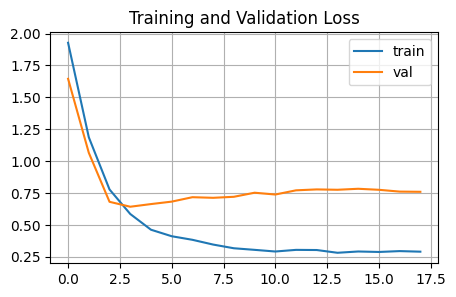

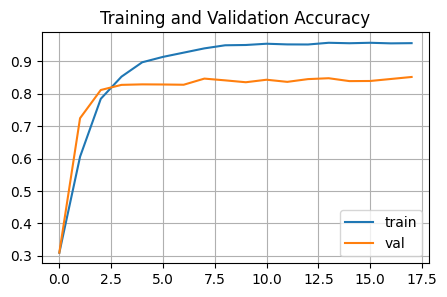

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.8254 - loss: 0.8407
accuracy of dl model is 0.8235294222831726


In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, smooth_idf=True, norm='l2', max_features=6000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


dlmodel = Sequential()

dlmodel.add(Input(shape=(X_train.shape[1],)))

dlmodel.add(Dense(32, activation='relu',kernel_regularizer=l2(1e-3)))
dlmodel.add(BatchNormalization())
dlmodel.add(Dropout(0.4))

# dlmodel.add(Dense(128, activation='relu'))
# dlmodel.add(BatchNormalization())
# dlmodel.add(Dropout(0.2))

dlmodel.add(Dense(128, activation='relu',kernel_regularizer=l2(1e-3)))
dlmodel.add(BatchNormalization())
dlmodel.add(Dropout(0.2))

dlmodel.add(Dense(32, activation='relu',kernel_regularizer=l2(1e-3)))
dlmodel.add(BatchNormalization())
dlmodel.add(Dropout(0.4))

dlmodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))
dlmodel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

dlmodel.summary()

es = EarlyStopping(monitor='loss', verbose=1, patience=4,restore_best_weights=True)
hist = dlmodel.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.25, batch_size=32,callbacks=[es])

plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

print(f"accuracy of dl model is {dlmodel.evaluate(X_test, y_test)[1]}")


## 9. Now , Building DL model using tokenization and padding technique

In [116]:

# M2 USING TOKENIZER AND PAD SEQUENCES
X_train,X_test,y_train,y_test = train_test_split(text_df['content'], text_df['sentiment'], test_size=0.2, random_state=23,shuffle=True)

text_Encoder = LabelEncoder()
y_train = text_Encoder.fit_transform(y_train)
y_test = text_Encoder.transform(y_test)
SENTIMENT_CLASS_NAMES = text_Encoder.classes_ 


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=6000, oov_token="OOV")
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
# word_index is a dict mapping each word → its assigned integer index

vocab_size = len(word_index)  # number of unique words seen

# input_dim = vocab_size + 1  # reserving index 0 for padding (the default of pad_sequences)
input_dim   = min(6000, vocab_size + 1)  #

print(f"input dim is {input_dim} and vocab_size is {vocab_size}")

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

MAX_LEN = max(len(x) for x in X_train )  # Find the maximum length of sequences

print(f"max len value is {MAX_LEN}")

X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')

input dim is 6000 and vocab_size is 8309
max len value is 35


In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# model1 = DecisionTreeClassifier( random_state=42)
# model1.fit(X_train, y_train)
# y_pred = model1.predict(X_test)

# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.33761682242990654


## 10. rnnmodel

In [121]:
from tensorflow.keras.layers import SimpleRNN,Embedding

rnnmodel = Sequential()
rnnmodel.add(Input(shape=(MAX_LEN,)))#to see parameter count,otherwise model willl not built 

rnnmodel.add(Embedding(input_dim=input_dim, output_dim=256))
rnnmodel.add(SimpleRNN(64, activation='tanh',return_sequences=True))
rnnmodel.add(Dropout(0.3))

rnnmodel.add(SimpleRNN(64, activation='tanh'))
rnnmodel.add(Dropout(0.3))

rnnmodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))  # For binary classification
rnnmodel.summary()

rnnmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = rnnmodel.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es])

loss, accuracy = rnnmodel.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 35, 256)        │     1,536,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 35, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,565,125 (5.97 MB)

 Trainable params: 1,565,125 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3041 - loss: 1.5994 - val_accuracy: 0.5039 - val_loss: 1.2741
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6180 - loss: 1.0451 - val_accuracy: 0.6364 - val_loss: 1.0299
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8194 - loss: 0.5444 - val_accuracy: 0.6335 - val_loss: 1.1651
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9054 - loss: 0.2951 - val_accuracy: 0.6760 - val_loss: 1.1481
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9546 - loss: 0.1518 - val_accuracy: 0.6605 - val_loss: 1.4142
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6144 - loss: 1.0773
Test Loss: 1.0581793785095215, Test Accuracy: 0.6242260336875916


## 11. Lstm model and its performance

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 35, 256)        │     1,536,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 35, 64)         │        73,984 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,677 (6.40 MB)

 Trainable params: 1,676,677 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3252 - loss: 1.5148 - val_accuracy: 0.6267 - val_loss: 0.9861
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8093 - loss: 0.5650 - val_accuracy: 0.8704 - val_loss: 0.3653
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9496 - loss: 0.1646 - val_accuracy: 0.8801 - val_loss: 0.3733
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9695 - loss: 0.0964 - val_accuracy: 0.8738 - val_loss: 0.4339
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9771 - loss: 0.0722 - val_accuracy: 0.8796 - val_loss: 0.4730
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9866 - loss: 0.0485 - val_accuracy: 0.8791 - val_loss: 0.4953
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8617 - loss: 0.3804
Test Loss: 0.37569865584373474, Test Accuracy: 0.8660990595817566


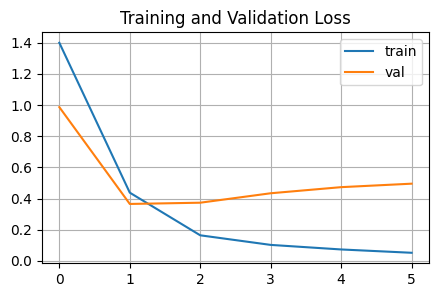

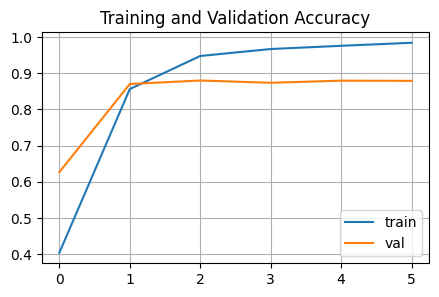

In [123]:
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional

lstmmodel = Sequential()
lstmmodel.add(Input(shape=(MAX_LEN,)))

lstmmodel.add(Embedding(input_dim=input_dim, output_dim=256))

lstmmodel.add(Bidirectional(LSTM(32, return_sequences=True)))
lstmmodel.add(Dropout(0.4))
lstmmodel.add(Bidirectional(LSTM(64)))
lstmmodel.add(Dropout(0.4))

lstmmodel.add(Dense(len(SENTIMENT_CLASS_NAMES), activation='softmax'))  
lstmmodel.summary()

lstmmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
hist = lstmmodel.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[es])

loss, accuracy = lstmmodel.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()


## 12. Saving the model

In [124]:
import pickle

pickle.dump(lr_best_model, open(os.path.join(Main_dir,'models','lr_best_model.pkl'), 'wb'))
# pickle.dump(sv_best_model, open(os.path.join(Main_dir,'models','sv_best_model.pkl'), 'wb'))
pickle.dump(text_Encoder,open(os.path.join(Main_dir,'models','text_Encoder.pkl'),'wb'))

#for dl part 
# pickle.dump(vectorizer,open(os.path.join(Main_dir,'models','vectorizer.pkl'),'wb'))
# dlmodel.save(os.path.join(Main_dir,'models','dlmodel.h5'))

#tokenizer part
pickle.dump(tokenizer,open(os.path.join(Main_dir,'models','tokenizer.pkl'),'wb'))
pickle.dump(MAX_LEN,open(os.path.join(Main_dir,'models','MAX_LEN.pkl'),'wb'))
lstmmodel.save(os.path.join(Main_dir,'models','lstmmodel.h5'))

## 13.Predicting from model

In [143]:
def predict_text_by_mlmodel(text,lr_model,text_Encoder):
    text = clean_content(text) #return string
    text = [text] #vectisers not take string as input so make it list
    y_pred = lr_model.predict(text) #lr model having y of label encode so return number in list ex [2]
    # print(y_pred)             #[2]
    emotion = text_Encoder.inverse_transform(y_pred) #corresponding label name , return list ex ['joy']
    # print(emotion)
    print(f"Predicted emotion: {emotion[0]}") 
    
def predict_text_by_dlmodel(text,lstm_model,text_Encoder,tokenizer,MAX_LEN):    
    text = clean_content(text) #return string
    text = [text] #vectisers not take string as input so make it list
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=MAX_LEN, padding='post', truncating='post')
    last_layer_output = lstm_model.predict(text)  
    # print(last_layer_output)               #[[0.0716216  0.28323117 0.31504422 0.15884334 0.17125972]] as last layer is softmax return 2d array
    number = np.argmax(last_layer_output,axis=1)  #return 1d array [2]
    emotion = text_Encoder.inverse_transform(number)  #corresponding label name , return list ex ['joy']
    print(f"Predicted emotion: {emotion[0]}")
    
    
text = "i am happy to day"    
predict_text_by_mlmodel(text,lr_best_model,text_Encoder)   
predict_text_by_dlmodel(text,lstmmodel,text_Encoder,tokenizer,MAX_LEN) 

Predicted emotion: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted emotion: joy


In [ ]:
#the end